In [4]:
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots 
include("other_utils.jl")


┌ Info: Precompiling ExpDataSets [502e9419-551d-40e3-9007-99df92d05256]
└ @ Base loading.jl:1423
┌ Warning: Package ExpDataSets does not have PyCall in its dependencies:
│ - If you have ExpDataSets checked out for development and have
│   added PyCall as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ExpDataSets
└ Loading PyCall into ExpDataSets from project dependency, future warnings for ExpDataSets are suppressed.
  ** incremental compilation may be fatally broken for this module **



agent_ps_plot (generic function with 1 method)

In [ ]:
et =  load("Data/behavior_dataset.jld2", "event_time_series")

In [6]:
oi=@chain begin 
    @subset(et, :agent.=="Object", :behavior.=="Immobility")
    select(:lfp, :file, :start_time, :end_time)
    @transform(@byrow :duration = duration(:lfp) )
    minimum(_.duration)
end

2.7997227997227583

In [10]:
ps =  @chain et begin 
    @subset( (:end_time .- :start_time).≥ 1.0)
    transform(:lfp => ByRow.(x->normalize(x))=>:lfp)
    transform(:lfp => ByRow.(x->binps(compute_power_spectrum(x),60,120))=>:pspec)
    @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end

,rat,trial_type,agent,behavior,region,pspec
,String7?,String15?,String7?,String15?,String,PowerSp…
1,RRSD18,Habituation,Robot,Sniff,ca2,"PowerSpectrum([3.07128e-6, 1.6631e-5, 3.02731e-5, 2.81422e-6, 1.12312e-5, 3.60622e-6, 4.30226e-6, 3.95264e-6, 8.67344e-7, 7.88867e-7, 2.14606e-6, 1.89445e-6, 1.30196e-6, 7.67026e-7, 1.43792e-6, 1.00663e-6, 8.51716e-7, 5.37997e-7, 1.02781e-6, 5.07848e-7, 7.0554e-7, 6.52163e-7, 7.74849e-7, 1.83409e-7, 5.24784e-7, 2.20538e-7, 1.64672e-7, 1.52227e-7, 1.13682e-7, 1.55158e-7, 2.38773e-9, 6.69584e-8, 7.01712e-8, 1.04539e-7, 1.1842e-7, 7.29219e-8, 2.09575e-7, 3.54007e-8, 8.52459e-8, 7.92033e-8, 9.09024e-8, 6.89e-8, 4.30581e-8, 2.17966e-8, 1.78056e-8, 5.15617e-8, 4.3149e-8, 3.42673e-8, 3.35996e-8, 1.49291e-8, 3.99216e-8, 3.44612e-8, 5.46452e-8, 3.9132e-8, 3.97313e-8, 3.37083e-8, 3.23738e-8, 3.03509e-8, 5.87783e-8, 1.72232e-8], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
2,RRSD18,Habituation,Robot,Sniff,mob,"PowerSpectrum([5.76937e-7, 2.91192e-5, 2.86523e-5, 9.87942e-6, 4.08209e-6, 5.67138e-6, 1.59866e-6, 3.25844e-7, 7.81232e-7, 5.24171e-7, 8.40265e-7, 1.49545e-7, 3.22669e-7, 1.62734e-7, 1.81137e-7, 9.48898e-8, 1.67852e-7, 8.56861e-8, 1.36645e-7, 1.37303e-7, 9.33778e-8, 1.52551e-7, 1.56977e-7, 1.57508e-7, 6.38986e-8, 1.69247e-7, 3.05481e-7, 2.29685e-7, 3.28459e-7, 6.08432e-7, 4.26249e-8, 3.53989e-7, 2.7069e-7, 2.27843e-7, 2.43599e-7, 1.67809e-7, 2.0633e-7, 2.06878e-7, 3.04442e-7, 3.99136e-7, 5.18641e-7, 2.56478e-7, 5.90491e-7, 4.53011e-7, 3.44427e-7, 5.32484e-7, 4.24327e-7, 2.38018e-7, 2.61669e-7, 1.20617e-7, 2.89779e-7, 1.44608e-7, 9.28711e-8, 1.80089e-7, 1.37095e-7, 9.35582e-8, 2.08882e-7, 9.94891e-8, 9.93096e-8, 1.15114e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
3,RRSD18,Habituation,Robot,Sniff,amyg,"PowerSpectrum([1.12679e-6, 2.99085e-5, 2.54006e-5, 5.13164e-6, 2.71074e-6, 2.97693e-6, 2.62494e-6, 2.57331e-6, 1.73094e-6, 1.39747e-6, 1.66669e-6, 9.434e-7, 1.56755e-6, 4.01384e-7, 6.3898e-7, 4.95707e-7, 4.73893e-7, 3.30798e-7, 4.44328e-7, 1.84121e-7, 4.34075e-7, 2.00276e-7, 6.17054e-7, 3.0307e-7, 4.54202e-7, 4.12314e-7, 5.37349e-7, 5.24015e-7, 8.6642e-7, 2.42368e-7, 2.89463e-8, 2.4932e-7, 1.91366e-7, 5.34186e-7, 4.61197e-7, 3.35911e-7, 6.26801e-7, 1.83613e-7, 3.09559e-7, 2.3172e-7, 1.79056e-7, 2.54542e-7, 3.32329e-7, 1.56137e-7, 2.82155e-7, 2.35436e-7, 3.07108e-7, 2.72614e-7, 1.18107e-7, 1.87497e-7, 1.27647e-7, 2.28446e-7, 7.28256e-8, 2.61554e-8, 1.13819e-7, 8.22419e-8, 1.65259e-7, 1.27976e-7, 2.29507e-7, 1.20566e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
4,RRSD28,OF,missing,Rear,ca2,"PowerSpectrum([2.55985e-6, 5.37457e-5, 0.000153703, 4.56067e-6, 2.55485e-5, 3.54725e-6, 7.0199e-6, 2.96612e-6, 2.28554e-6, 6.5766e-6, 3.15979e-6, 4.83251e-6, 1.565e-6, 1.20812e-6, 3.63908e-8, 4.25799e-6, 9.66808e-7, 1.1891e-6, 2.23956e-7, 9.30962e-7, 8.23132e-7, 5.84708e-7, 5.3579e-7, 1.45586e-6, 3.08673e-7, 6.14183e-7, 7.56936e-7, 7.71745e-8, 1.07159e-7, 8.16468e-8, 4.65175e-8, 4.06413e-7, 5.73846e-7, 1.51727e-7, 9.87261e-8, 2.92952e-7, 1.2672e-7, 2.01279e

In [11]:
null_region_mps =  @chain ps begin 
    @subset(:behavior.=="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:region])
    @combine(:mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:region, :mpsvals=>:mps, :err)
end

,region,mps
,String,Array…
1,mob,"[3.36831e-6, 2.26293e-5, 1.91724e-5, 2.1313e-5, 2.21379e-5, 1.3764e-5, 5.00028e-6, 3.87559e-6, 3.13089e-6, 2.74588e-6, 1.87489e-6, 1.49723e-6, 8.41635e-7, 1.08616e-6, 7.37046e-7, 7.52496e-7, 6.57471e-7, 6.79267e-7, 5.3721e-7, 5.41362e-7, 6.40694e-7, 4.21981e-7, 4.67766e-7, 5.27359e-7, 6.46145e-7, 6.55057e-7, 6.81704e-7, 7.91539e-7, 1.06312e-6, 5.88544e-7, 7.31755e-8, 6.3843e-7, 8.85807e-7, 9.19112e-7, 8.37594e-7, 7.99879e-7, 7.7023e-7, 7.40114e-7, 6.4932e-7, 5.22485e-7, 6.81181e-7, 7.79352e-7, 6.51069e-7, 5.14479e-7, 5.95372e-7, 6.59854e-7, 5.37925e-7, 4.97829e-7, 5.31794e-7, 4.90232e-7, 5.27471e-7, 4.33091e-7, 3.70782e-7, 3.56976e-7, 3.163e-7, 3.43684e-7, 2.62102e-7, 2.45097e-7, 2.35375e-7, 2.41679e-7]"
2,ca2,"[3.9062e-6, 2.23986e-5, 1.70623e-5, 1.5526e-5, 4.03935e-5, 9.61344e-6, 3.59698e-6, 2.91877e-6, 3.75917e-6, 2.4544e-6, 2.30724e-6, 1.69458e-6, 1.48922e-6, 1.21362e-6, 1.3639e-6, 1.0063e-6, 9.97226e-7, 8.58381e-7, 7.75117e-7, 8.44183e-7, 6.36043e-7, 7.69739e-7, 7.72637e-7, 4.29522e-7, 5.45459e-7, 4.54663e-7, 4.23124e-7, 3.8681e-7, 3.83474e-7, 3.22293e-7, 3.6242e-8, 2.10072e-7, 2.69461e-7, 2.51277e-7, 2.69964e-7, 1.98181e-7, 2.16705e-7, 2.37787e-7, 2.0398e-7, 1.9648e-7, 1.82818e-7, 1.73693e-7, 1.39993e-7, 1.6374e-7, 1.35972e-7, 1.73236e-7, 1.26365e-7, 1.79907e-7, 1.65901e-7, 1.4353e-7, 1.51915e-7, 1.26088e-7, 1.25989e-7, 1.34407e-7, 1.33851e-7, 1.34122e-7, 1.31162e-7, 1.22215e-7, 1.35803e-7, 1.20953e-7]"
3,amyg,"[4.18874e-6, 2.26206e-5, 1.65787e-5, 9.68399e-6, 1.31839e-5, 6.32063e-6, 3.86754e-6, 3.44939e-6, 2.90775e-6, 2.80833e-6, 2.44544e-6, 1.87139e-6, 1.76956e-6, 1.51467e-6, 1.12983e-6, 1.15837e-6, 9.77713e-7, 9.59282e-7, 9.2815e-7, 7.57913e-7, 7.16786e-7, 8.28873e-7, 7.81115e-7, 6.88809e-7, 8.07416e-7, 7.36614e-7, 8.18035e-7, 7.87725e-7, 7.66015e-7, 5.8076e-7, 7.45818e-8, 5.21869e-7, 7.07837e-7, 6.84032e-7, 8.26472e-7, 6.53727e-7, 6.43432e-7, 5.53951e-7, 5.46003e-7, 4.91387e-7, 5.2984e-7, 5.41152e-7, 5.53688e-7, 4.76304e-7, 3.55693e-7, 4.59703e-7, 4.28525e-7, 5.2599e-7, 4.87174e-7, 4.18944e-7, 3.97158e-7, 3.93073e-7, 3.97246e-7, 3.81907e-7, 3.96886e-7, 3.58795e-7, 3.91694e-7, 3.13214e-7, 3.56041e-7, 2.7615e-7]"


In [17]:
ps

,rat,trial_type,agent,behavior,region,pspec
,String7?,String15?,String7?,String15?,String,PowerSp…
1,RRSD18,Habituation,Robot,Sniff,ca2,"PowerSpectrum([3.07128e-6, 1.6631e-5, 3.02731e-5, 2.81422e-6, 1.12312e-5, 3.60622e-6, 4.30226e-6, 3.95264e-6, 8.67344e-7, 7.88867e-7, 2.14606e-6, 1.89445e-6, 1.30196e-6, 7.67026e-7, 1.43792e-6, 1.00663e-6, 8.51716e-7, 5.37997e-7, 1.02781e-6, 5.07848e-7, 7.0554e-7, 6.52163e-7, 7.74849e-7, 1.83409e-7, 5.24784e-7, 2.20538e-7, 1.64672e-7, 1.52227e-7, 1.13682e-7, 1.55158e-7, 2.38773e-9, 6.69584e-8, 7.01712e-8, 1.04539e-7, 1.1842e-7, 7.29219e-8, 2.09575e-7, 3.54007e-8, 8.52459e-8, 7.92033e-8, 9.09024e-8, 6.89e-8, 4.30581e-8, 2.17966e-8, 1.78056e-8, 5.15617e-8, 4.3149e-8, 3.42673e-8, 3.35996e-8, 1.49291e-8, 3.99216e-8, 3.44612e-8, 5.46452e-8, 3.9132e-8, 3.97313e-8, 3.37083e-8, 3.23738e-8, 3.03509e-8, 5.87783e-8, 1.72232e-8], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
2,RRSD18,Habituation,Robot,Sniff,mob,"PowerSpectrum([5.76937e-7, 2.91192e-5, 2.86523e-5, 9.87942e-6, 4.08209e-6, 5.67138e-6, 1.59866e-6, 3.25844e-7, 7.81232e-7, 5.24171e-7, 8.40265e-7, 1.49545e-7, 3.22669e-7, 1.62734e-7, 1.81137e-7, 9.48898e-8, 1.67852e-7, 8.56861e-8, 1.36645e-7, 1.37303e-7, 9.33778e-8, 1.52551e-7, 1.56977e-7, 1.57508e-7, 6.38986e-8, 1.69247e-7, 3.05481e-7, 2.29685e-7, 3.28459e-7, 6.08432e-7, 4.26249e-8, 3.53989e-7, 2.7069e-7, 2.27843e-7, 2.43599e-7, 1.67809e-7, 2.0633e-7, 2.06878e-7, 3.04442e-7, 3.99136e-7, 5.18641e-7, 2.56478e-7, 5.90491e-7, 4.53011e-7, 3.44427e-7, 5.32484e-7, 4.24327e-7, 2.38018e-7, 2.61669e-7, 1.20617e-7, 2.89779e-7, 1.44608e-7, 9.28711e-8, 1.80089e-7, 1.37095e-7, 9.35582e-8, 2.08882e-7, 9.94891e-8, 9.93096e-8, 1.15114e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
3,RRSD18,Habituation,Robot,Sniff,amyg,"PowerSpectrum([1.12679e-6, 2.99085e-5, 2.54006e-5, 5.13164e-6, 2.71074e-6, 2.97693e-6, 2.62494e-6, 2.57331e-6, 1.73094e-6, 1.39747e-6, 1.66669e-6, 9.434e-7, 1.56755e-6, 4.01384e-7, 6.3898e-7, 4.95707e-7, 4.73893e-7, 3.30798e-7, 4.44328e-7, 1.84121e-7, 4.34075e-7, 2.00276e-7, 6.17054e-7, 3.0307e-7, 4.54202e-7, 4.12314e-7, 5.37349e-7, 5.24015e-7, 8.6642e-7, 2.42368e-7, 2.89463e-8, 2.4932e-7, 1.91366e-7, 5.34186e-7, 4.61197e-7, 3.35911e-7, 6.26801e-7, 1.83613e-7, 3.09559e-7, 2.3172e-7, 1.79056e-7, 2.54542e-7, 3.32329e-7, 1.56137e-7, 2.82155e-7, 2.35436e-7, 3.07108e-7, 2.72614e-7, 1.18107e-7, 1.87497e-7, 1.27647e-7, 2.28446e-7, 7.28256e-8, 2.61554e-8, 1.13819e-7, 8.22419e-8, 1.65259e-7, 1.27976e-7, 2.29507e-7, 1.20566e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
4,RRSD28,OF,missing,Rear,ca2,"PowerSpectrum([2.55985e-6, 5.37457e-5, 0.000153703, 4.56067e-6, 2.55485e-5, 3.54725e-6, 7.0199e-6, 2.96612e-6, 2.28554e-6, 6.5766e-6, 3.15979e-6, 4.83251e-6, 1.565e-6, 1.20812e-6, 3.63908e-8, 4.25799e-6, 9.66808e-7, 1.1891e-6, 2.23956e-7, 9.30962e-7, 8.23132e-7, 5.84708e-7, 5.3579e-7, 1.45586e-6, 3.08673e-7, 6.14183e-7, 7.56936e-7, 7.71745e-8, 1.07159e-7, 8.16468e-8, 4.65175e-8, 4.06413e-7, 5.73846e-7, 1.51727e-7, 9.87261e-8, 2.92952e-7, 1.2672e-7, 2.01279e

In [27]:
behavior_mps =  @chain ps begin 
    @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:behavior, :region])
    @combine(:mps = [meanandstderr(:pspec)])
    transform(:mps => ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps => ByRow.(x->Measurements.uncertainty.(x)) => :err)
    select( :behavior, :region, :mpsvals=>:mps, :err)
end

,behavior,region,mps
,String15?,String,Array…
1,Sniff,ca2,"[4.5617e-6, 3.27934e-5, 1.95752e-5, 2.05514e-5, 5.10595e-5, 1.11954e-5, 4.58078e-6, 4.02352e-6, 4.56709e-6, 3.73648e-6, 2.84299e-6, 2.55724e-6, 1.97973e-6, 1.56637e-6, 1.40264e-6, 1.30547e-6, 1.42966e-6, 1.23144e-6, 1.09897e-6, 8.68104e-7, 8.96195e-7, 8.24674e-7, 7.6642e-7, 6.86364e-7, 6.19825e-7, 5.95691e-7, 5.0638e-7, 5.07606e-7, 4.58791e-7, 3.3598e-7, 4.71203e-8, 2.95759e-7, 3.71559e-7, 3.37838e-7, 2.9743e-7, 2.97992e-7, 2.91541e-7, 2.50794e-7, 2.4388e-7, 2.32374e-7, 2.34697e-7, 2.19794e-7, 2.17762e-7, 2.01173e-7, 2.23261e-7, 2.00323e-7, 2.04026e-7, 1.80465e-7, 2.04522e-7, 1.87698e-7, 1.85275e-7, 1.70773e-7, 1.71536e-7, 1.82847e-7, 1.90431e-7, 1.59811e-7, 1.79529e-7, 1.74033e-7, 1.80441e-7, 1.70165e-7]"
2,Sniff,mob,"[3.72713e-6, 2.87965e-5, 2.16561e-5, 3.08432e-5, 2.92363e-5, 1.44109e-5, 6.54726e-6, 5.57591e-6, 3.8864e-6, 2.99665e-6, 2.32774e-6, 1.60969e-6, 1.49176e-6, 1.21757e-6, 1.13196e-6, 8.86411e-7, 9.59567e-7, 8.0237e-7, 7.02611e-7, 6.01752e-7, 5.61545e-7, 6.10596e-7, 6.50419e-7, 6.25307e-7, 6.40722e-7, 7.43242e-7, 8.26373e-7, 1.06038e-6, 1.47456e-6, 9.74493e-7, 1.0723e-7, 8.34582e-7, 1.07505e-6, 9.81072e-7, 8.9738e-7, 9.63134e-7, 9.24697e-7, 8.37618e-7, 7.5019e-7, 8.35065e-7, 7.85307e-7, 7.45112e-7, 7.77144e-7, 7.17063e-7, 6.78653e-7, 6.96775e-7, 7.41167e-7, 6.49506e-7, 6.98308e-7, 5.76259e-7, 5.73336e-7, 5.4374e-7, 5.46644e-7, 4.17643e-7, 4.69243e-7, 4.43465e-7, 3.99553e-7, 3.70183e-7, 3.43742e-7, 3.25505e-7]"
3,Sniff,amyg,"[4.98111e-6, 3.86442e-5, 1.73186e-5, 1.31913e-5, 1.83792e-5, 7.50813e-6, 4.62726e-6, 4.39147e-6, 3.61082e-6, 3.64111e-6, 3.19161e-6, 2.53066e-6, 2.24445e-6, 1.94922e-6, 1.70459e-6, 1.48698e-6, 1.49559e-6, 1.3593e-6, 1.1236e-6, 1.01414e-6, 9.99193e-7, 9.28634e-7, 9.58599e-7, 8.46259e-7, 8.83712e-7, 9.65234e-7, 9.51587e-7, 1.08019e-6, 1.09699e-6, 7.57003e-7, 1.04428e-7, 7.15386e-7, 9.13858e-7, 8.41531e-7, 7.77706e-7, 8.3474e-7, 7.82531e-7, 7.32582e-7, 6.47339e-7, 6.38864e-7, 6.56535e-7, 5.75709e-7, 6.2378e-7, 5.58615e-7, 6.0462e-7, 5.59647e-7, 5.53201e-7, 5.01402e-7, 5.29391e-7, 5.17768e-7, 4.67972e-7, 4.33109e-7, 4.47346e-7, 4.50519e-7, 4.70678e-7, 4.41435e-7, 4.52472e-7, 4.53162e-7, 4.29182e-7, 4.21972e-7]"
4,Rear,ca2,"[3.63482e-6, 2.78378e-5, 1.69389e-5, 1.52835e-5, 4.24227e-5, 9.53913e-6, 4.03357e-6, 3.29664e-6, 3.81387e-6, 3.05824e-6, 2.49015e-6, 2.2928e-6, 1.82706e-6, 1.45999e-6, 1.23591e-6, 1.22539e-6, 9.14864e-7, 8.42152e-7, 8.34927e-7, 7.78274e-7, 7.43697e-7, 6.78402e-7, 6.55698e-7, 6.09143e-7, 5.42147e-7, 4.96398e-7, 4.42054e-7, 4.37662e-7, 4.44401e-7, 2.74272e-7, 3.44166e-8, 2.53815e-7, 3.11199e-7, 2.82365e-7, 2.66372e-7, 2.36844e-7, 2.32689e-7, 2.24121e-7, 1.89317e-7, 1.87561e-7, 1.86486e-7, 1.76183e-7, 1.81118e-7, 1.61762e-7, 1.59117e-7, 1.52068e-7, 1.63554e-7, 1.52083e-7, 1.40668e-7, 1.36204e-7, 1.33193e-7, 1.3843e-7, 1.35169e-7, 1.40048e-7, 1.40779e-7, 1.25451e-7, 1.4934e-7, 1.43414e-7, 1.37868e-7, 1.34469e-7]"
5,Rear,amyg,"[4.2875e-6, 3.00983e-5, 1.53142e-5, 1.02953e-5, 1.46902e-5, 6.39626e-6, 3.86789e-6, 3.6795e-6, 3.39276e-6, 2.95298e-6, 2.48215e-6, 2.3322e-6, 2.00246e-6, 1.78621e-6, 1.47e-6, 1.49058e-6, 1.15374e-6, 1.12921e-6, 1.04949e-6, 9.69004e-7, 9.39069e-7, 8.64618e-7, 9.78532e-7, 8.3862e-7, 8.02802e-7, 9.49147e-7, 9.64105e-7, 9.76664e-7, 9.99175e-7, 7.45443e-7, 9.47592e-8, 6.38728e-7, 8.70266e-7, 7.78242e-7, 7.62859e-7, 7.37497e-7, 6.97708e-7, 6.72301e-7, 6.46318e-7, 6.06327e-7, 6.19463e-7, 6.08033e-7, 5.69741e-7, 5.7623e-7, 5.30963e-7, 4.98056e-7, 4.71834e-7, 4.77362e-7, 4.33204e-7, 4.17503e-7, 4.07554e-7, 4.20382e-7, 3.80124e-7, 3.91468e-7, 3.94407e-7, 3.67058e-7, 4.02225e-7, 3.75687e-7, 3.55609e-7, 3.58138e-7]"
6,Rear,mob,"[2.81312e-6, 2.46941e-5, 2.1254e-5, 2.65863e-5, 2.63759e-5, 1.27695e-5, 5.0804e-6, 4.59727e-6, 3.7127e-6, 2.52101e-6, 2.0784e-6, 1.66207e-6, 1.22377e-6, 9.97864e-7, 9.26082e-7, 8.93281e-7, 8.09578e-7, 7.3281e-7, 6.25546e-7, 6.53532e-7, 6.03437e-7, 6.07908e-7, 6.36499e-7, 6.20536e-7, 5.79463e-7,

In [28]:
@subset(behavior_mps,  :behavior.=="Immobility", :region.=="amyg").mps

1-element Vector{Vector{Float64}}:
 [2.7762741887546576e-6, 2.123008787186138e-5, 1.1851352029323083e-5, 7.754608759985469e-6, 1.055824312648107e-5, 4.1515169275984255e-6, 2.930947898848036e-6, 1.9661054372870373e-6, 2.17405363167753e-6, 1.9698596718849685e-6  …  2.552533348875992e-7, 2.3497511830974177e-7, 2.554136445630007e-7, 2.3792892264801604e-7, 2.4629750267361933e-7, 3.104870959311448e-7, 2.5615594381201093e-7, 2.149970915697205e-7, 2.416792916367565e-7, 2.4021798152993536e-7]

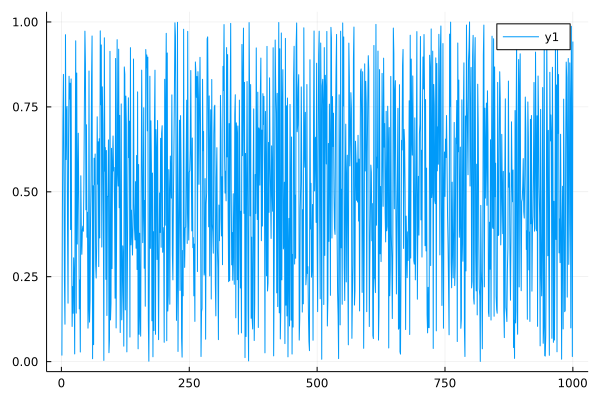

In [54]:
freqs=2:2:120;  b="Immobility"; r="amyg"
s=@subset(behavior_mps, :behavior.== b, :region.==lowercase(r))
labels = r
specs = s.mps
errs = s.err

 gr()
# p=plot(
#     freqs, 
#     specs, 
#     ribbon=errs, 
#     fillalpha=.2, 
#     # label=labels, 
#     # xaxis=:log,
#     # yaxis=:log, 
#     ylabel="Power Spectral Density", 
#     xlabel="Frequency (Hz)", 
#     title=b*"\n"*r,
#     linewidth=2.5,
#     grid=false, 
# )

p=plot(rand(1000))
display(p)

In [37]:
freqs=2:2:120;  b="Immobility";  r="Amyg" 
s=@subset(behavior_mps, :behavior.== b, :region.==lowercase(r))

# labels =reshape(s.agent,1,length(s.agent)) 
labels = r
specs = s.mps
errs = s.err

gr()
p=plot(
    freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    # label=labels, 
    xaxis=:log,
    yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=b*"\n"*r,
    linewidth=2.5,
    grid=false,
    
)
# ns=@subset(null_region_mps, :region.== lowercase(r))
# plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(2,120), linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="Agent")




1-element Vector{Vector{Float64}}:
 [2.7212938646389267e-7, 1.7634200013676893e-6, 9.776133114370788e-7, 6.934452749358383e-7, 1.0378050618697577e-6, 3.065784667724485e-7, 3.433249486999605e-7, 1.4216803138267568e-7, 2.2493780802892908e-7, 1.7164052039359533e-7  …  2.1247783012792536e-8, 2.0656221129590003e-8, 3.0852239921493745e-8, 2.639444183629921e-8, 2.806321239029232e-8, 4.172677959853465e-8, 3.0377635680761414e-8, 1.5353524017919763e-8, 2.4571423879743085e-8, 2.477401018923571e-8]

In [2]:
# import PyPlot
# pyplot()
# imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
# plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density")
# imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
# plot!(imm_amyg, title="Amygdala", xlabel="")
# imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
# plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
# rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
# plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
# rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
# plot!(rear_amyg, title="", xlabel="Frequency Hz")
# rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
# plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

# p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
# plot!(p, grid=false, size = (1100, 600))
# plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# # plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")


LoadError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.
